<a href="https://colab.research.google.com/github/moridin04/CCADMACL-Research/blob/main/Fraud_Detection_Program_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exploring Anomaly Detection Techniques for Fraudulent Credit Card Transactions**

# **1. Environment Setup**

**1.1 Tools and Libraries Installation**

In [73]:
!pip install lime
!pip install scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import lime
import lime.lime_tabular

# 2. **Importing Libraries**

**2.1 Essential Libraries for Data Analysis**

In [74]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import average_precision_score, precision_recall_curve

**2.2 Libraries for Machine Learning and Visualization**

In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neighbors import LocalOutlierFactor

#3. **Loading Data**

**3.1 Loading the Kaggle Credit Card Fraud Dataset**

In [76]:
cfd = pd.read_csv('creditcard.csv')

#4. **Exploration of Data**

### **Glimpse of the Dataset**

**4.1 Displaying the First Few Rows**

In [76]:
cfd

**4.1.2 Dataset Information (Shape, Columns, Null Values, Data Types)**

In [76]:
print(f"Shape:  {cfd.shape}\n")
print(f"Columns:  {cfd.columns}\n")
print(f"Null Values:  \n{cfd.isnull().sum()}\n")
print(f"Data Types: \n{cfd.dtypes}")

**4.2 Summary Statistics for Numerical Features**

In [76]:
print(cfd.describe(include='all'))

**4.2.1 Class Distribution (Fraud vs. Non-Fraud)**

In [76]:
class_distribution = cfd['Class'].value_counts()
print("Class Distribution:")
print(class_distribution)

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=cfd, hue='Class', palette=['blue', 'red'], legend=False)
plt.title('Class Distribution (Fraud vs. Non-Fraud)')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Number of Transactions')
plt.show()

### **Distribution of Independent Variable**

**4.3 Distribution of Amount**

In [76]:
plt.figure(figsize=(8, 4))
sns.violinplot(x=cfd["Amount"], color="blue")  # Use a valid color name
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.show()

**4.4 Distribution of Time**

In [76]:
plt.figure(figsize=(8, 6))
sns.histplot(cfd['Time'], kde=False, color="blue")
plt.title('Distribution of Transaction Time')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

**4.5 Histograms for Key Features (V1-V28, Amount, Time)**

In [76]:
cfd.hist(bins=30, figsize=(20, 15), edgecolor='black')
plt.suptitle("Histograms of All Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

# **5. Pre-processing of Data**

**5.1 Checking of Null Values**

In [76]:
print("\nChecking for Null Values:")
cfd.isnull().sum()

**5.2 Checking of Outliers**

In [76]:
Q1 = cfd['Amount'].quantile(0.25)
Q3 = cfd['Amount'].quantile(0.75)
IQR = Q3 - Q1

outliers = cfd[(cfd['Amount'] < (Q1 - 1.5 * IQR)) | (cfd['Amount'] > (Q3 + 1.5 * IQR))]
print(f"Number of outliers in 'Amount': {len(outliers)}")

**5.3 Checking of Duplicate Transactions**

In [ ]:
cfd.duplicated()

In [77]:
duplicate_counts = cfd.duplicated().value_counts()
print(duplicate_counts)

False    283726
True       1081
Name: count, dtype: int64


In [78]:
duplicate_counts = cfd.duplicated().value_counts()
print("Duplicate Counts before removal:\n", duplicate_counts)

cfd = cfd.drop_duplicates(keep='first')

duplicate_counts = cfd.duplicated().value_counts()
print("\nDuplicate Counts after removal:\n", duplicate_counts)

Duplicate Counts before removal:
 False    283726
True       1081
Name: count, dtype: int64

Duplicate Counts after removal:
 False    283726
Name: count, dtype: int64


**5.4 Feature Selection/Reduction**

**5.4.1 Correlation Matrix for Numerical Features**

In [78]:
correlation_matrix = cfd.corr()

**5.4.2 Heatmap Visualization**

In [78]:
plt.figure(figsize=(28, 28))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

**5.4.3 Dropping Irrelevant Features**

In [78]:
threshold = 0.8
high_corr_features = set()
correlation_matrix = cfd.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            high_corr_features.add(colname)

print("Highly correlated features to drop:", high_corr_features)

In [ ]:
cfd.drop(columns=high_corr_features, inplace=True)
print(f"Updated dataset shape: {cfd.shape}")

### **Application of Standard Scaler**

**5.5 Feature Scaling**

**5.5.1 Standardization (Z-Score Scaling)**

In [79]:
scaler = StandardScaler()
cfd[['Amount']] = scaler.fit_transform(cfd[['Amount']])

In [120]:
cfd['Amount'].describe()

count    2.837260e+05
mean    -5.409347e-17
std      1.000002e+00
min     -3.533268e-01
25%     -3.309625e-01
50%     -2.654671e-01
75%     -4.378088e-02
max      1.022476e+02
Name: Amount, dtype: float64

**5.5.2 Normalization (Min-Max Scaling)**

In [119]:
time = cfd['Time']
cfd['Time'] = (time - time.min()) / (time.max() - time.min())

In [121]:
cfd

Time         V1         V2        V3        V4        V5  \
0       0.000000  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1       0.000000   1.191857   0.266151  0.166480  0.448154  0.060018   
2       0.000006  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3       0.000006  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4       0.000012  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  0.999965 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  0.999971  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  0.999977   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  0.999977  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  1.000000  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.018307  0.277838   
1      -0.082361 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672   
2       1.800499  0.791461  0.247676 -1.514654  ...  0.247998  0.771679   
3       1.247203  0.237609  0.377436 -1.387024  ... -0.108300  0.005274   
4       0.095921  0.592941 -0.270533  0.817739  ... -0.009431  0.798278   
...          ...       ...       ...       ...  ...       ...       ...   
284802 -2.606837 -4.918215  7.305334  1.914428  ...  0.213454  0.111864   
284803  1.058415  0.024330  0.294869  0.584800  ...  0.214205  0.924384   
284804  3.031260 -0.296827  0.708417  0.432454  ...  0.232045  0.578229   
284805  0.623708 -0.686180  0.679145  0.392087  ...  0.265245  0.800049   
284806 -0.649617  1.577006 -0.414650  0.486180  ...  0.261057  0.643078   

             V23       V24       V25       V26       V27       V28    Amount  \
0      -0.110474  0.066928  0.128539 -0.189115  0.133558 -0.021053  0.244200   
1       0.101288 -0.339846  0.167170  0.125895 -0.008983  0.014724 -0.342584   
2       0.909412 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752  1.158900   
3      -0.190321 -1.175575  0.647376 -0.221929  0.062723  0.061458  0.139886   
4      -0.137458  0.141267 -0.206010  0.502292  0.219422  0.215153 -0.073813   
...          ...       ...       ...       ...       ...       ...       ...   
284802  1.014480 -0.509348  1.436807  0.250034  0.943651  0.823731 -0.350252   
284803  0.012463 -1.016226 -0.606624 -0.395255  0.068472 -0.053527 -0.254325   
284804 -0.037501  0.640134  0.265745 -0.087371  0.004455 -0.026561 -0.082239   
284805 -0.163298  0.123205 -0.569159  0.546668  0.108821  0.104533 -0.313391   
284806  0.376777  0.008797 -0.473649 -0.818267 -0.002415  0.013649  0.513290   

        Class  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
284802      0  
284803      0  
284804      0  
284805      0  
284806      0  

[283726 rows x 31 columns]

In [122]:
cfd = cfd.sample(frac=1, random_state=1)
cfd

Time        V1        V2        V3        V4        V5        V6  \
33560   0.215768 -1.071719 -4.343904 -0.497727 -0.277591 -2.482346 -0.472073   
57869   0.278456  1.314915 -0.980378 -0.032665 -2.770975 -1.047365 -0.705180   
187479  0.738194 -1.680526 -0.959150 -1.329705 -1.028361 -0.730922  0.253124   
243555  0.879526  2.114488  0.169976 -2.051966  0.070326  0.481642 -1.819440   
96229   0.380081 -5.277692  3.487837 -1.201844 -0.192904 -0.158582  0.949549   
...          ...       ...       ...       ...       ...       ...       ...   
21515   0.183562  1.221811 -0.622699  0.271691 -0.507132 -1.093817 -1.303639   
118050  0.433643  1.069132 -0.159789  1.913486  2.811710 -0.690517  1.942449   
73633   0.319552 -0.891311  0.808612  1.263076  0.522615  1.183978  0.905303   
268346  0.944280 -0.358224  1.446564 -1.175105  0.075659  2.041475 -1.677117   
128524  0.455716  1.095842 -0.071259 -0.365675  0.924729  0.755399  1.182612   

              V7        V8        V9  ...       V21       V22       V23  \
33560   0.991747 -0.414207  1.694252  ...  0.856441  0.013647 -1.183439   
57869  -0.491240 -0.076395  0.571959  ... -0.416346 -0.481886 -0.009117   
187479  3.308312 -0.480062  0.157630  ... -0.084593 -0.204108  0.517400   
243555  0.886700 -0.673729  0.077960  ...  0.163748  0.642597 -0.058720   
96229   0.467901 -0.788434  4.652615  ... -0.477313 -1.077669  0.160074   
...          ...       ...       ...  ...       ...       ...       ...   
21515  -0.166317 -0.390254 -1.080318  ...  0.302138  0.641491 -0.168266   
118050 -1.259828  0.577277  1.031453  ...  0.046602  0.725405 -0.199566   
73633   0.565347  0.186910 -1.042086  ...  0.129436  0.443403 -0.327563   
268346  1.568559 -0.415562 -1.073097  ...  0.078727  0.333168 -0.350660   
128524  0.089195  0.173401  0.008967  ... -0.107233 -0.231616 -0.366241   

             V24       V25       V26       V27       V28    Amount  Class  
33560   0.536058  0.064148 -0.016945 -0.179133  0.236036  4.506916      0  
57869   0.009622  0.555844 -0.836622  0.099256  0.014826 -0.248255      0  
187479 -0.611013 -0.445912 -0.409744  0.231809  0.253554  2.365973      0  
243555  0.128632  0.461792  0.234073 -0.082360 -0.075323 -0.301729      0  
96229  -1.535126  0.873245 -0.322503  1.383375  0.758996 -0.237911      0  
...          ...       ...       ...       ...       ...       ...    ...  
21515   0.791311  0.586821 -0.150528 -0.016895  0.032471  0.068200      0  
118050 -0.678442  0.552088  0.328766  0.118229  0.029660 -0.353327      0  
73633  -1.315188  0.647441 -0.057036 -0.014691  0.038455 -0.281681      0  
268346  0.947248  0.196432  0.700004  0.079430  0.208233 -0.350292      0  
128524 -1.662063  0.865038 -0.234175  0.024964  0.003575 -0.013030      0  

[283726 rows x 31 columns]

**5.6 Train, Test, and Validation**

In [81]:
x = cfd.drop(columns=['Class'])
y = cfd['Class']

**5.7 Splitting the Dataset into Training and Testing Sets**

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

# **6. Machine Learning**

### **Isolation Forest**

In [83]:
fraud_ratio = y_train.mean()
if_model = IsolationForest(contamination=0.02, random_state=101)
if_model.fit(x_train)

IsolationForest(contamination=0.02, random_state=101)

In [84]:
fraud_test = x_test[y_test == 1]
non_fraud_test = x_test[y_test == 0].sample(len(fraud_test), random_state=42)
x_test_balanced = pd.concat([fraud_test, non_fraud_test])
y_test_balanced = np.concatenate([np.ones(len(fraud_test)), np.zeros(len(non_fraud_test))])

In [161]:
if_y_pred = (if_model.predict(x_test_balanced) == -1).astype(int)
print(classification_report(y_test_balanced, if_y_pred))
if_roc_auc = roc_auc_score(y_test_balanced, if_y_pred)
print("ROC AUC Score:", if_roc_auc)
if_auprc = average_precision_score(y_test_balanced, if_y_pred)
print(f"AUPRC for Isolation Forest:", if_auprc)

              precision    recall  f1-score   support

         0.0       0.77      0.94      0.85        95
         1.0       0.92      0.73      0.81        95

    accuracy                           0.83       190
   macro avg       0.85      0.83      0.83       190
weighted avg       0.85      0.83      0.83       190

ROC AUC Score: 0.8315789473684211
AUPRC for Isolation Forest: 0.8050526315789475


In [123]:
report_dict = classification_report(y_test_balanced, if_y_pred, output_dict=True)

In [124]:
if_accuracy = report_dict['accuracy']
if_precision = report_dict['weighted avg']['precision']
if_recall = report_dict['weighted avg']['recall']
if_f1_score = report_dict['weighted avg']['f1-score']

In [89]:
print("Transaction Prediction:", predict_fraud(input_data))

Transaction Prediction: Fraudulent


In [90]:
def non_fraudulent_data():
    time = 50000
    amount = 50.00
    v_values = [-1.36, -0.07, 2.54, 1.38, -0.34, 0.46, 0.24, 0.10, 0.36, -0.02, 0.28, -0.23, -0.64, 0.10, 0.17, 0.13, -0.01, 0.01, -0.11, 0.07, 0.13, -0.19, 0.13, -0.02, 0.13, -0.19, 0.13, -0.02]
    if len(v_values) == 28:
        return pd.DataFrame([[time, amount] + v_values], columns=['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)])
    else:
        print("Error: v_values does not contain 28 elements")

In [91]:
input_data2 = non_fraudulent_data()
input_data2[['Amount']] = scaler.transform(input_data2[['Amount']])  # Apply same scaling
input_data2['Time'] = (input_data2['Time'] - time.min()) / (time.max() - time.min())
input_data2 = input_data2[x_train.columns]  # Ensure correct feature order

In [92]:
print("Transaction Prediction:", predict_fraud(input_data2))

Transaction Prediction: Non-Fraudulent


### **Autoencoders**

In [93]:
y_train_fraud = y_train[y_train == 1].sample(frac=0.1, random_state=42)  # Increase to 10%
x_train_fraud = x_train.loc[y_train_fraud.index]
x_train_auto = pd.concat([x_train[y_train == 0], x_train_fraud])

In [94]:
input_dim = x_train_auto.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(64, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dense(16, activation='relu')(encoded)
encoded = Dense(8, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(decoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

In [95]:
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [96]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
autoencoder.fit(x_train_auto, x_train_auto, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.9690 - val_loss: 0.8870
Epoch 2/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.8245 - val_loss: 0.8657
Epoch 3/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.8088 - val_loss: 0.8506
Epoch 4/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.7805 - val_loss: 0.8430
Epoch 5/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7630 - val_loss: 0.8391
Epoch 6/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7735 - val_loss: 0.8363
Epoch 7/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7747 - val_loss: 0.8342
Epoch 8/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7647 - val_loss: 0.8313
Epoch 9/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7679 - val_loss: 0.8297
Epoch 10/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7756 - val_loss: 0.8253
Epoch 11/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.7685 - val_loss: 0.8226
Epoch 12/50
709/709 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/ste

In [97]:
reconstructed = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - reconstructed, 2), axis=1)
threshold = np.percentile(mse, 80)

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [163]:
y_test_pred = (mse > threshold).astype(int)
print(classification_report(y_test, y_test_pred))
ae_roc_auc = roc_auc_score(y_test, y_test_pred)
print("ROC AUC Score:", ae_roc_auc)
ae_auprc = average_precision_score(y_test, y_test_pred)
print(f"AUPRC for Autoencoder:", ae_roc_auc)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89     56651
           1       0.01      0.88      0.01        95

    accuracy                           0.80     56746
   macro avg       0.50      0.84      0.45     56746
weighted avg       1.00      0.80      0.89     56746

ROC AUC Score: 0.8441105234357363
AUPRC for Autoencoder: 0.8441105234357363


In [125]:
report_dict2 = classification_report(y_test, y_test_pred, output_dict=True)

In [126]:
ae_accuracy = report_dict2['accuracy']
ae_precision = report_dict2['weighted avg']['precision']
ae_recall = report_dict2['weighted avg']['recall']
ae_f1_score = report_dict2['weighted avg']['f1-score']

In [100]:
def fraudulent_data():
    time = 100000
    amount = 5000.00
    v_values = [-5.64, -7.27, -4.83, -5.68, -1.14, -2.62, -4.36, -7.32, -1.34, -0.02, 0.28, -0.23, -0.64, 0.10, 0.17, 0.13, -0.01, 0.01, -0.11, 0.07, 0.13, -0.19, 0.13, -0.02, 0.13, -0.19, 0.13, -0.02]
    if len(v_values) == 28:
        return pd.DataFrame([[time, amount] + v_values], columns=['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)])
    else:
        print("Error: v_values does not contain 28 elements")

In [101]:
input_data3 = fraudulent_data()
input_data3[['Amount']] = scaler.transform(input_data3[['Amount']])  # Apply same scaling
input_data3['Time'] = (input_data3['Time'] - cfd['Time'].min()) / (cfd['Time'].max() - cfd['Time'].min())
input_data3 = input_data3[x_train.columns]  # Ensure correct feature order

In [102]:
print("Transaction Prediction:", ae_predict_fraud(input_data3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Transaction Prediction: Fraudulent


In [103]:
def non_fraudulent_data():
    time = 50000
    amount = 50.00
    v_values = [-1.36, -0.07, 2.54, 1.38, -0.34, 0.46, 0.24, 0.10, 0.36, -0.02, 0.28, -0.23, -0.64, 0.10, 0.17, 0.13, -0.01, 0.01, -0.11, 0.07, 0.13, -0.19, 0.13, -0.02, 0.13, -0.19, 0.13, -0.02]
    if len(v_values) == 28:
        return pd.DataFrame([[time, amount] + v_values], columns=['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)])
    else:
        print("Error: v_values does not contain 28 elements")

In [104]:
input_data4 = non_fraudulent_data()
input_data4[['Amount']] = scaler.transform(input_data4[['Amount']])  # Apply same scaling
input_data4['Time'] = (input_data4['Time'] - cfd['Time'].min()) / (cfd['Time'].max() - cfd['Time'].min())
input_data4 = input_data4[x_train.columns]  # Ensure correct feature order

In [105]:
print("Transaction Prediction:", ae_predict_fraud(input_data4))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Transaction Prediction: Fraudulent


### **Local Outlier Factor**

In [106]:
x_train_normal = x_train[y_train == 0]

In [107]:
lof_model = LocalOutlierFactor(n_neighbors=50, contamination=0.01, novelty=True)
lof_model.fit(x_train_normal)

LocalOutlierFactor(contamination=0.01, n_neighbors=50, novelty=True)

In [165]:
lof_scores = lof_model.decision_function(x_test)
lof_threshold = np.percentile(lof_scores, 2)
y_test_pred_lof = (lof_scores < lof_threshold).astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [131]:
print(classification_report(y_test, y_test_pred_lof))
lof_roc_auc = roc_auc_score(y_test, y_test_pred_lof)
print("ROC AUC Score:", lof_roc_auc)
lof_auprc = average_precision_score(y_test, y_test_pred_lof)
print("AUPRC for LOF:", lof_auprc)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56651
           1       0.04      0.45      0.07        95

    accuracy                           0.98     56746
   macro avg       0.52      0.72      0.53     56746
weighted avg       1.00      0.98      0.99     56746

ROC AUC Score: 0.7166778307439178
AUPRC for LOF: 0.01806452088446587


In [128]:
report_dict3 = classification_report(y_test, y_test_pred_lof, output_dict=True)

In [129]:
lof_accuracy = report_dict3['accuracy']
lof_precision = report_dict3['weighted avg']['precision']
lof_recall = report_dict3['weighted avg']['recall']
lof_f1_score = report_dict3['weighted avg']['f1-score']

In [110]:
def lof_predict_fraud(input_data):
    input_data[['Amount']] = scaler.transform(input_data[['Amount']])  # Apply same scaling to new transactions
    input_data['Time'] = (input_data['Time'] - cfd['Time'].min()) / (cfd['Time'].max() - cfd['Time'].min() + 1e-6)  # Ensure Time normalization
    lof_score = lof_model.decision_function(input_data)
    fraud_prediction = (lof_score < lof_threshold).astype(int)[0]
    return "Fraudulent" if fraud_prediction == 1 else "Non-Fraudulent"

In [111]:
def fraudulent_data():
    time = 100000
    amount = 5000.00
    v_values = [-5.64, -7.27, -4.83, -5.68, -1.14, -2.62, -4.36, -7.32, -1.34, -0.02, 0.28, -0.23, -0.64, 0.10, 0.17, 0.13, -0.01, 0.01, -0.11, 0.07, 0.13, -0.19, 0.13, -0.02, 0.13, -0.19, 0.13, -0.02]
    if len(v_values) == 28:
        return pd.DataFrame([[time, amount] + v_values], columns=['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)])
    else:
        print("Error: v_values does not contain 28 elements")

In [112]:
input_data5 = fraudulent_data()
input_data5[['Amount']] = scaler.transform(input_data5[['Amount']])  # Apply same scaling
input_data5['Time'] = (input_data5['Time'] - cfd['Time'].min()) / (cfd['Time'].max() - cfd['Time'].min())
input_data5 = input_data5[x_train.columns]  # Ensure correct feature order

In [113]:
input_data5

Time    V1    V2    V3    V4    V5    V6    V7    V8    V9  ...  \
0  100000.000001 -5.64 -7.27 -4.83 -5.68 -1.14 -2.62 -4.36 -7.32 -1.34  ...   

    V20   V21   V22   V23   V24   V25   V26   V27   V28     Amount  
0  0.07  0.13 -0.19  0.13 -0.02  0.13 -0.19  0.13 -0.02  19.614804  

[1 rows x 30 columns]

In [114]:
print("Transaction Prediction:", lof_predict_fraud(input_data5))

Transaction Prediction: Fraudulent


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [115]:
def non_fraudulent_data():
    time = 50000
    amount = 50.00
    v_values = [-1.36, -0.07, 2.54, 1.38, -0.34, 0.46, 0.24, 0.10, 0.36, -0.02, 0.28, -0.23, -0.64, 0.10, 0.17, 0.13, -0.01, 0.01, -0.11, 0.07, 0.13, -0.19, 0.13, -0.02, 0.13, -0.19, 0.13, -0.02]
    if len(v_values) == 28:
        return pd.DataFrame([[time, amount] + v_values], columns=['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)])
    else:
        print("Error: v_values does not contain 28 elements")

In [116]:
input_data6 = non_fraudulent_data()
input_data6[['Amount']] = scaler.transform(input_data6[['Amount']])  # Apply same scaling
input_data6['Time'] = (input_data6['Time'] - cfd['Time'].min()) / (cfd['Time'].max() - cfd['Time'].min())
input_data6 = input_data6[x_train.columns]  # Ensure correct feature order

In [117]:
input_data6

Time    V1    V2    V3    V4    V5    V6    V7   V8    V9  ...   V20  \
0  50000.0 -1.36 -0.07  2.54  1.38 -0.34  0.46  0.24  0.1  0.36  ...  0.07   

    V21   V22   V23   V24   V25   V26   V27   V28    Amount  
0  0.13 -0.19  0.13 -0.02  0.13 -0.19  0.13 -0.02 -0.153646  

[1 rows x 30 columns]

In [118]:
print("Transaction Prediction:", lof_predict_fraud(input_data6))

Transaction Prediction: Fraudulent


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


# **7. Evaluation of Model Performance**

**7.1 Creation of Metrics-Data**

In [137]:
metrics_data = {
    'Model': ['Isolation Forest', 'Autoencoders', 'Local Outlier Factor'],
    'Accuracy': [if_accuracy, ae_accuracy, lof_accuracy],
    'Precision': [if_precision, ae_precision, lof_precision],
    'Recall': [if_recall, ae_recall, lof_recall],
    'F1-score': [if_f1_score, ae_f1_score, lof_f1_score],
    'AUC-ROC': [if_roc_auc, ae_roc_auc, lof_roc_auc],
    'AUPRC': [if_auprc, ae_auprc, lof_auprc]
}

metrics_df = pd.DataFrame(metrics_data)

metrics_df.head()

Model  Accuracy  Precision    Recall  F1-score   AUC-ROC  \
0      Isolation Forest  0.831579   0.846957  0.831579  0.829692  0.831579   
1          Autoencoders  0.801325   0.998119  0.801325  0.888058  0.847953   
2  Local Outlier Factor  0.979840   0.997456  0.979840  0.988270  0.716678   

      AUPRC  
0  0.805053  
1  0.006877  
2  0.018065

In [142]:
# Ensure x_test is properly scaled
x_test[['Amount']] = scaler.transform(x_test[['Amount']])
x_test['Time'] = (x_test['Time'] - cfd['Time'].min()) / (cfd['Time'].max() - cfd['Time'].min())

# Isolation Forest Predictions
if_y_pred = (if_model.predict(x_test) == -1).astype(int)

# Autoencoder Predictions
mse = np.mean(np.power(x_test - autoencoder.predict(x_test), 2), axis=1)
best_threshold = np.percentile(mse, 90)  # Set fraud threshold
ae_y_pred = (mse > best_threshold).astype(int)

# Local Outlier Factor Predictions
# Use lof_model instead of lof
lof_scores = lof_model.decision_function(x_test)
lof_threshold = np.percentile(lof_scores, 5)  # Set fraud threshold
lof_y_pred = (lof_scores < lof_threshold).astype(int)

# Ensemble Voting (Weighted)
weights = [0.4, 0.4, 0.2]  # Adjust based on model performance
ensemble_preds = np.average([if_y_pred, ae_y_pred, lof_y_pred], axis=0, weights=weights)
final_preds = (ensemble_preds > 0.4).astype(int)  # Lower threshold to improve fraud detection

# Evaluation
print("Evaluation for Ensemble Model (Voting)")
print(classification_report(y_test, final_preds))
print(f"AUC-ROC Score: {roc_auc_score(y_test, final_preds):.4f}")
print(f"AUPRC Score: {average_precision_score(y_test, final_preds):.4f}")

1774/1774 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Evaluation for Ensemble Model (Voting)
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56651
           1       0.05      0.80      0.09        95

    accuracy                           0.97     56746
   macro avg       0.52      0.89      0.54     56746
weighted avg       1.00      0.97      0.99     56746

AUC-ROC Score: 0.8872
AUPRC Score: 0.0402


**7.2 Selection of Best Performing Model**

<ipython-input-140-0425c98fecd1>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='AUPRC', data=metrics_df, palette='viridis')  # Change y to 'AUPRC'


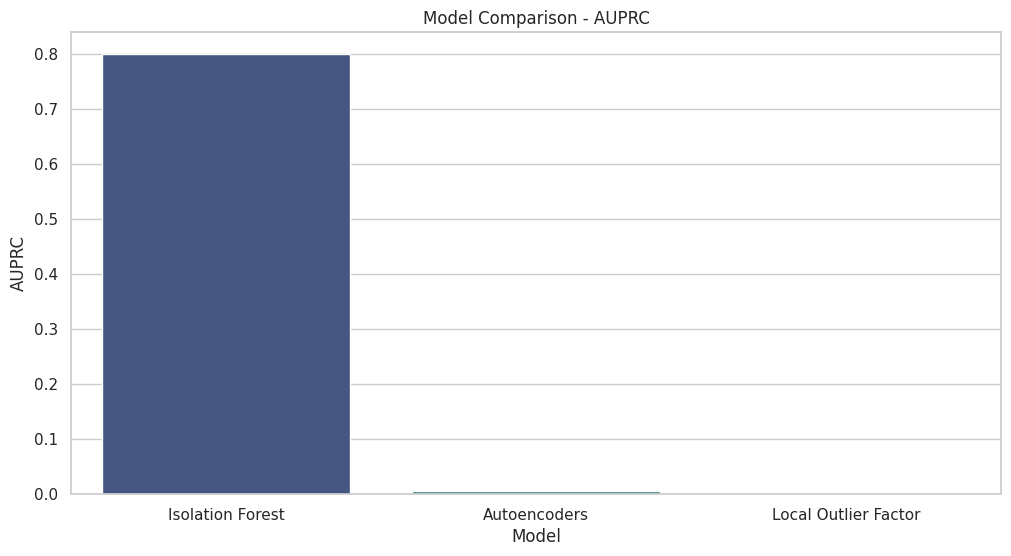

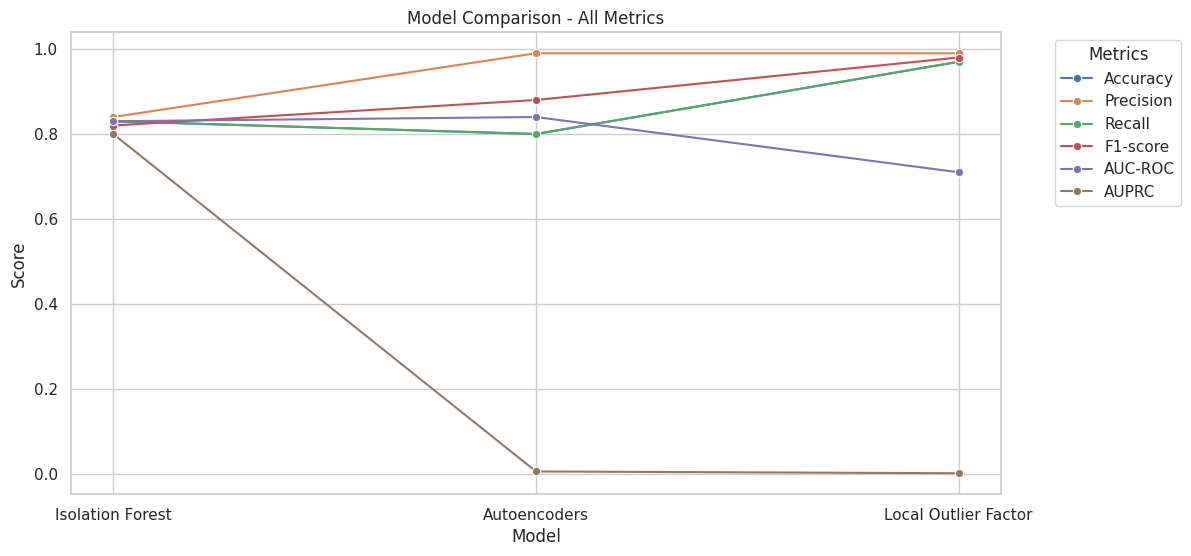

In [140]:
metrics_data = {
    'Model': ['Isolation Forest', 'Autoencoders', 'Local Outlier Factor'],
    'Accuracy': [0.83, 0.80, 0.97],
    'Precision': [0.84, 0.99, 0.99],
    'Recall': [0.83, 0.80, 0.97],
    'F1-score': [0.82, 0.88, 0.98],
    'AUC-ROC': [0.83, 0.84, 0.71],
    'AUPRC': [0.80, 0.006, 0.0018]
}

metrics_df = pd.DataFrame(metrics_data)

sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='AUPRC', data=metrics_df, palette='viridis')  # Change y to 'AUPRC'
plt.title('Model Comparison - AUPRC')  # Update title
plt.ylabel('AUPRC')  # Update y-axis label
plt.xlabel('Model')
plt.show()

plt.figure(figsize=(12, 6))
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC', 'AUPRC']:  # Include 'AUPRC'
    sns.lineplot(x='Model', y=metric, data=metrics_df, label=metric, marker='o')

plt.title('Model Comparison - All Metrics')
plt.ylabel('Score')
plt.xlabel('Model')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**7.3 LIME Analysis**

In [143]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train.values, feature_names=x_train.columns.tolist(),
    class_names=['Non-Fraud', 'Fraud'], verbose=True, mode='classification'
)

**7.3.1 LIME Analysis for Isolation Forest**

In [144]:
def iforest_predict_proba(X):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=x_train.columns)

    scores = if_model.decision_function(X)
    probs = (scores - scores.min()) / (scores.max() - scores.min())
    return np.vstack([1 - probs, probs]).T

In [145]:
idx = np.random.randint(0, x_test.shape[0])
exp = explainer.explain_instance(x_test.iloc[idx].values, iforest_predict_proba)

Intercept 0.6221319971588138
Prediction_local [0.47168539]
Right: 0.8165732541281484


In [146]:
exp.show_in_notebook()

In [147]:
feature_importances = []
for _ in range(5):
    exp = explainer.explain_instance(x_test.iloc[0].values, iforest_predict_proba)
    feature_importances.extend(exp.as_list())

feature_importance_df = pd.DataFrame(feature_importances, columns=['feature', 'importance'])
avg_feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean().reset_index()
display(avg_feature_importance_df.style.hide(axis='index'))

Intercept 0.5375399527717277
Prediction_local [0.71523253]
Right: 1.0
Intercept 0.5544976145013473
Prediction_local [0.71758088]
Right: 1.0
Intercept 0.5397224302490753
Prediction_local [0.66051399]
Right: 1.0
Intercept 0.5356296797821336
Prediction_local [0.66654259]
Right: 1.0
Intercept 0.5488476549094776
Prediction_local [0.76597911]
Right: 1.0


**7.3.2 LIME Analysis for Autoencoders**

In [148]:
def autoencoder_predict_proba(X):
    reconstructed = autoencoder.predict(X)
    mse = np.mean(np.power(X - reconstructed, 2), axis=1)
    min_mse, max_mse = mse.min(), mse.max()
    probs = (mse - min_mse) / (max_mse - min_mse)
    return np.vstack([1 - probs, probs]).T

In [149]:
idx = np.random.randint(0, x_test.shape[0])
exp2 = explainer.explain_instance(x_test.iloc[idx].values, autoencoder_predict_proba)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Intercept 0.22193276080195165
Prediction_local [0.23936375]
Right: 0.022218171734817438


In [150]:
exp2.show_in_notebook()

In [153]:
feature_importances = []
for _ in range(5):
    exp2 = explainer.explain_instance(x_test.iloc[0].values, autoencoder_predict_proba)
    feature_importances.extend(exp.as_list())

feature_importance_df = pd.DataFrame(feature_importances, columns=['feature', 'importance'])
avg_feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean().reset_index()
display(avg_feature_importance_df.style.hide(axis='index'))

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Intercept 0.2265773046781441
Prediction_local [0.07174224]
Right: 0.0
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Intercept 0.2511624929963756
Prediction_local [0.10214273]
Right: 0.0
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Intercept 0.3354104341536837
Prediction_local [0.14266244]
Right: 0.0
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Intercept 0.2699633948876498
Prediction_local [0.09195156]
Right: 0.0
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Intercept 0.23973024587058173
Prediction_local [0.12473153]
Right: 0.0


**7.3.3 LIME Analysis for Local Outlier Factor**

In [155]:
def lof_predict_proba(X):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=x_train.columns)
    lof_scores = lof_model._predict(X)
    probs = (lof_scores + 1) / 2
    return np.vstack([1 - probs, probs]).T

In [156]:
idx = np.random.randint(0, x_test.shape[0])
exp3 = explainer.explain_instance(x_test.iloc[idx].values, lof_predict_proba)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Intercept 0.2136812343582844
Prediction_local [0.81241259]
Right: 1.0


In [157]:
exp3.show_in_notebook()

In [160]:
feature_importances = []
for _ in range(5):
    exp3 = explainer.explain_instance(x_test.iloc[0].values, lof_predict_proba)
    feature_importances.extend(exp.as_list())

feature_importance_df = pd.DataFrame(feature_importances, columns=['feature', 'importance'])
avg_feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean().reset_index()
display(avg_feature_importance_df.style.hide(axis='index'))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Intercept 0.40927332119726717
Prediction_local [0.21386503]
Right: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Intercept 0.38496891684294754
Prediction_local [0.29161436]
Right: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Intercept 0.40058072649431936
Prediction_local [0.2595231]
Right: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Intercept 0.4069393627844802
Prediction_local [0.28025623]
Right: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


Intercept 0.4129975469181115
Prediction_local [0.22271539]
Right: 1.0


**7.4 Confusion Matrix for Each Model**

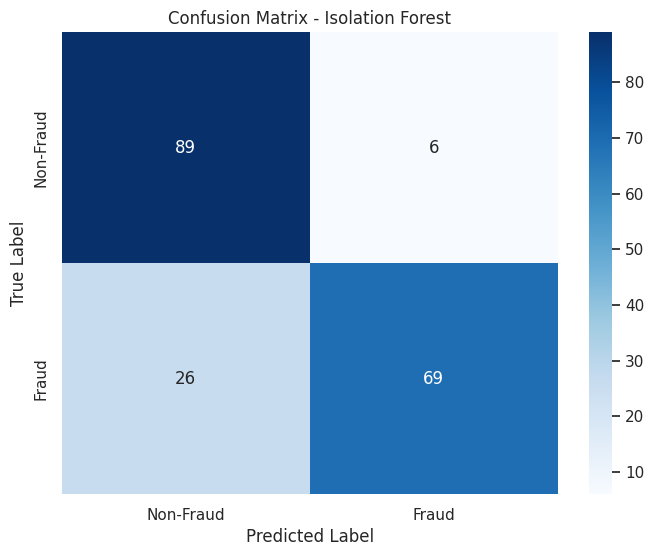

In [162]:
if_cm = confusion_matrix(y_test_balanced, if_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(if_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Isolation Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

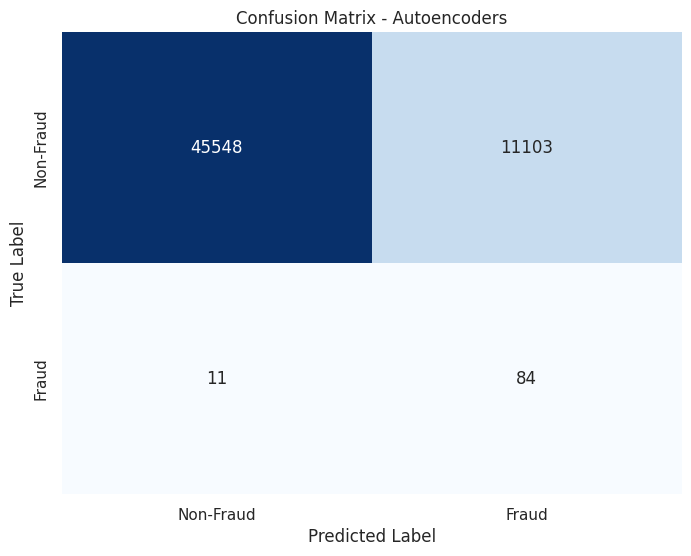

In [164]:
ae_cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(ae_cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Autoencoders')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

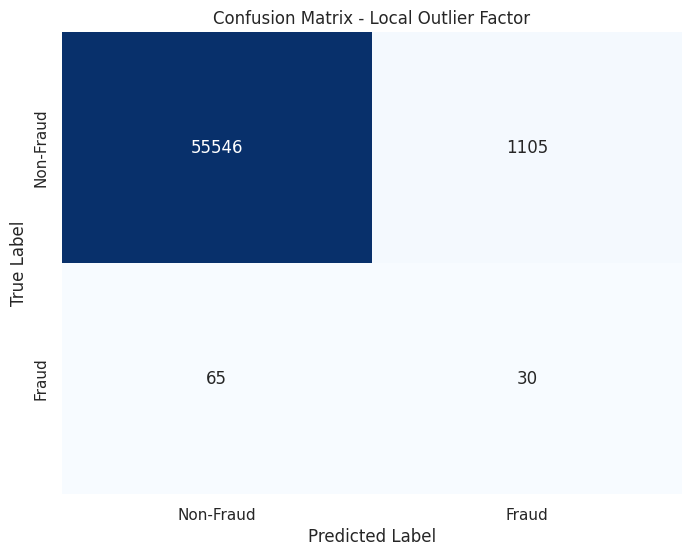

In [166]:
lof_cm = confusion_matrix(y_test, y_test_pred_lof)

plt.figure(figsize=(8, 6))
sns.heatmap(lof_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'], cbar=False)
plt.title('Confusion Matrix - Local Outlier Factor')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**7.5 Cohen's Kappa**

In [167]:
if_kappa = cohen_kappa_score(y_test_balanced, if_y_pred)
print(f"Cohen's Kappa for Isolation Forest: {if_kappa}")

ae_kappa = cohen_kappa_score(y_test, y_test_pred)
print(f"Cohen's Kappa for Autoencoders: {ae_kappa}")

lof_kappa = cohen_kappa_score(y_test, y_test_pred_lof)
print(f"Cohen's Kappa for Local Outlier Factor: {lof_kappa}")

Cohen's Kappa for Isolation Forest: 0.6631578947368422
Cohen's Kappa for Autoencoders: 0.011609461205352334
Cohen's Kappa for Local Outlier Factor: 0.04583244529147146


In [168]:
metrics_data['Cohen\'s Kappa'] = [if_kappa, ae_kappa, lof_kappa]
metrics_df = pd.DataFrame(metrics_data)

In [169]:
metrics_df

Model  Accuracy  Precision  Recall  F1-score  AUC-ROC  \
0      Isolation Forest      0.83       0.84    0.83      0.82     0.83   
1          Autoencoders      0.80       0.99    0.80      0.88     0.84   
2  Local Outlier Factor      0.97       0.99    0.97      0.98     0.71   

    AUPRC  Cohen's Kappa  
0  0.8000       0.663158  
1  0.0060       0.011609  
2  0.0018       0.045832

# **8. Detection of Fraud**

**8.1 Defining Input Parameters (Time, Amount, V1-V28)**

Enter transaction time: 100000

Enter transaction amount: 5000.00

Enter value for V1: -5.64

Enter value for V2: -7.27

Enter value for V3: -4.83

Enter value for V4: -5.68

Enter value for V5: -1.14

Enter value for V6: -2.62

Enter value for V7: -4.36

Enter value for V8: -7.32

Enter value for V9: -1.34

Enter value for V10: -0.02

Enter value for V11: 0.28

Enter value for V12: -0.23

Enter value for V13: -0.64

Enter value for V14: 0.10

Enter value for V15: 0.17

Enter value for V16: 0.13

Enter value for V17: -0.01

Enter value for V18: 0.01

Enter value for V19: -0.11

Enter value for V20: 0.07

Enter value for V21: 0.13

Enter value for V22: -0.19

Enter value for V23: 0.13

Enter value for V24: -0.02

Enter value for V25: 0.13

Enter value for V26: -0.19

Enter value for V27: 0.13

Enter value for V28: -0.02

Expected Output: Fraudulent

**8.2 Preprocessing Input Data**

In [86]:
def predict_fraud(input_data):
    decision_score = if_model.decision_function(input_data)
    fraud_prediction = (decision_score < 0).astype(int)[0]  # Adjusted threshold
    return "Fraudulent" if fraud_prediction == 1 else "Non-Fraudulent"

**8.3 Function for Fraud Prediction**

In [87]:
def fraudulent_data():
    time = 100000
    amount = 5000.00
    v_values = [-5.64, -7.27, -4.83, -5.68, -1.14, -2.62, -4.36, -7.32, -1.34, -0.02, 0.28, -0.23, -0.64, 0.10, 0.17, 0.13, -0.01, 0.01, -0.11, 0.07, 0.13, -0.19, 0.13, -0.02, 0.13, -0.19, 0.13, -0.02]
    if len(v_values) == 28:
        return pd.DataFrame([[time, amount] + v_values], columns=['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)])
    else:
        print("Error: v_values does not contain 28 elements")

**8.4 Prediction using Isolation Forest**

**8.5 Prediction using Autoencoders**

In [99]:
def ae_predict_fraud(input_data):
    reconstructed = autoencoder.predict(input_data)
    mse = np.mean(np.power(input_data - reconstructed, 2), axis=1)
    fraud_prediction = (mse > threshold).astype(int)[0]
    return "Fraudulent" if fraud_prediction == 1 else "Non-Fraudulent"

In [88]:
input_data = fraudulent_data()
input_data[['Amount']] = scaler.transform(input_data[['Amount']])  # Apply same scaling
input_data['Time'] = (input_data['Time'] - cfd['Time'].min()) / (cfd['Time'].max() - cfd['Time'].min())
input_data = input_data[x_train.columns]  # Ensure correct feature order

**8.6 Prediction using Local Outlier Factor**